In [382]:
from pyorbit.subroutines.common import np
import pyorbit.subroutines.constants as constants
import pyorbit.subroutines.kepler_exo as kepler_exo
from pyorbit.models.abstract_model import AbstractModel
from pyorbit.models.abstract_transit import *
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d

from PyAstronomy import modelSuite as PyAstroModelSuite


try:
    from numba import jit
    @jit(nopython=True)
    def CCF_gauss(x, A, x0, fwhm):
        sigma = fwhm/2.35482004503
        return 1. - A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

    @jit(nopython=True)
    def iter2_CCF_gauss(x, A, fwhm, x0, istar, out):
        sigma = fwhm/2.35482004503
        const = (2 * sigma ** 2)

        for i in range(x0.shape[0]):
            for j in range(x0.shape[1]):
                out[i,j, :] = istar[i, j] * (1. - A * np.exp(-(x - x0[i, j]) ** 2 /const))
        return out
except:

    def CCF_gauss(x, A, x0, fwhm):
        sigma = fwhm/2.35482004503
        return 1. - A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

    def iter2_CCF_gauss(x, A, fwhm, x0, istar, out):
        sigma = fwhm/2.35482004503
        const = (2 * sigma ** 2)

        for i in range(x0.shape[0]):
            for j in range(x0.shape[1]):
                out[i,j, :] = istar[i, j] * (1. - A * np.exp(-(x - x0[i, j]) ** 2 /const))
        return out



class RossiterMcLaughlin_Precise():
    model_class = 'rossiter_mclaughlin'

    def __init__(self, *args, **kwargs):
        import warnings
        from scipy.optimize import OptimizeWarning
        warnings.filterwarnings("ignore", category=OptimizeWarning)

        self.unitary_model = False

        # Must be moved here because it will updated depending on the selected limb darkening
        self.list_pams_common = {
            'P',  # Period, log-uniform prior
            'e',  # eccentricity, uniform prior
            'omega',  # argument of pericenter (in radians)
            'lambda', # Sky-projected angle between stellar rotation axis and normal of orbit plane [deg]
            'R_Rs',  # planet radius (in units of stellar radii)
            'v_sini' # projected rotational velocity of the star
        }

        self.star_grid = {}   # write an empty dictionary


        self.use_differential_rotation = kwargs.get('use_differential_rotation', False)

        #start filling the dictionary with relevant parameters
        self.star_grid['n_grid'] = kwargs.get('star_ngrid', 1001 )
        print(self.star_grid['n_grid'])
        self.star_grid['half_grid'] = int((self.star_grid['n_grid'] - 1) / 2)
        self.star_grid['time_step'] = kwargs.get('time_step', 149 ) # in seconds

        """ Coordinates of the centers of each grid cell (add offset) """
        self.star_grid['xx'] = np.linspace(-1.000000, 1.000000, self.star_grid['n_grid'], dtype=np.double)
        self.star_grid['xc'], self.star_grid['yc'] = np.meshgrid(self.star_grid['xx'], self.star_grid['xx'], indexing='xy')
        # check the Note section of the wiki page of meshgrid
        # https://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html

        """ Distance of each grid cell from the center of the stellar disk """
        self.star_grid['rc'] = np.sqrt(self.star_grid['xc'] ** 2 + self.star_grid['yc'] ** 2)
        # Must avoid negative numbers inside the square root
        self.star_grid['inside'] = self.star_grid['rc'] < 1.000000
        # Must avoid negative numbers inside the square root
        self.star_grid['outside'] = self.star_grid['rc'] >= 1.000000


        """ Determine the mu angle for each grid cell, as a function of radius. """
        self.star_grid['mu'] = np.zeros([self.star_grid['n_grid'], self.star_grid['n_grid']],dtype=np.double)  # initialization of the matrix with the mu values
        self.star_grid['mu'][self.star_grid['inside']] = np.sqrt(1. - self.star_grid['rc'][self.star_grid['inside']] ** 2)

        """ Values valid for HARPS-N data"""
        self.ccf_variables = {
            'natural_broadening': 1.5,  # in km/s
            'natural_contrast': 0.5, # relative depth o
            'instrumental_broadening': 1.108, # in km/s
            'rv_min': -20.0,
            'rv_max': 20.0,
            'rv_step': 0.50,
        }

        for dict_name in self.ccf_variables:
            try:
                self.ccf_variables[dict_name] = kwargs[dict_name]
            except:
                pass
                
        self.star_grid['zz'] = np.arange(self.ccf_variables['rv_min'],
                                        self.ccf_variables['rv_max']+self.ccf_variables['rv_step'],
                                        self.ccf_variables['rv_step'],
                                        dtype=np.double)
        self.star_grid['len_zz'] = len(self.star_grid['zz'])
        self.star_grid['rv_step'] = self.ccf_variables['rv_step']

        self.mu_step = 0.00001
        self.mu_integral = np.arange(0.,1.+self.mu_step, self.mu_step)
        
    def compute(self, parameter_values, x0_input, exptime):

        """
        :param parameter_values:
        :param dataset:
        :param x0_input:
        :return:
        """

        ld_par = parameter_values['ld_coeff']

        lambda_rad = parameter_values['lambda'] * constants.deg2rad
        inclination_rad = parameter_values['i'] * constants.deg2rad
        omega_rad = parameter_values['omega'] * constants.deg2rad

        """ Limb darkening law and coefficients """
        star_grid_I = self.compute_limb_darkening(ld_par, self.star_grid['mu'])
        star_grid_I[self.star_grid['outside']] = 0.000

        """ Intensity normalization"""
        star_grid_I /= np.sum(star_grid_I)

        star_grid_x_ortho = self.star_grid['xc'] * np.cos(lambda_rad) \
            - self.star_grid['yc'] * np.sin(lambda_rad)  # orthogonal distances from the spin-axis
        star_grid_y_ortho = self.star_grid['xc'] * np.sin(lambda_rad) \
            + self.star_grid['yc'] * np.cos(lambda_rad)


        star_grid_r_ortho = np.sqrt(star_grid_x_ortho ** 2 + star_grid_y_ortho** 2)
        star_grid_z_ortho = star_grid_r_ortho * 0.  # initialization of the matrix
        star_grid_z_ortho[self.star_grid['inside']] = np.sqrt(
            1. -star_grid_r_ortho[self.star_grid['inside']] ** 2)

        if self.use_differential_rotation:
            istar_rad = parameter_values['i_star'] * constants.deg2rad

            """ rotate the coordinate system around the x_ortho axis by an angle: """
            star_grid_beta = (np.pi / 2.) - istar_rad

            """ orthogonal distance from the stellar equator """
            ### Equation 7 in Cegla+2016
            star_grid_yp_ortho = star_grid_z_ortho * np.sin(star_grid_beta) \
                + star_grid_y_ortho * np.cos(star_grid_beta)

            ### Equation 6 in Cegla+2016
            #star_grid_zp_ortho = star_grid_z_ortho * np.cos(star_grid_beta) \
            #    + star_grid_y_ortho * np.sin(star_grid_beta)

            """ stellar rotational velocity for a given position """
            # differential rotation is included considering a sun-like law
            star_grid_v_star = star_grid_x_ortho * parameter_values['v_sini'] * (
                1. -parameter_values['alpha_rotation'] * star_grid_yp_ortho ** 2)
            # Null velocity for points outside the stellar surface
        else:
            star_grid_v_star = star_grid_x_ortho * parameter_values['v_sini']

        """ Addition of the convective contribute"""
        star_grid_v_star += self.retrieve_convective_rv(ld_par, self.star_grid['mu'], parameter_values)
        
        star_grid_v_star[self.star_grid['outside']] = 0.0


        """ working arrays for Eq. 1 and 9 of Cegla+2016"""
        star_grid_muI = star_grid_I * self.star_grid['mu']
        star_grid_v_starI = star_grid_I * star_grid_v_star


        out_temp = np.empty([self.star_grid['n_grid'], self.star_grid['n_grid'], self.star_grid['len_zz']])
        star_grid_ccf = iter2_CCF_gauss(self.star_grid['zz'],
                            self.ccf_variables['natural_contrast'],
                            self.ccf_variables['natural_broadening'],
                            star_grid_v_star, star_grid_I, out_temp)


        bjd = x0_input
        exptime = np.ones_like(bjd) * exptime

        rv_rml = np.zeros_like(bjd)
        cont_out = np.zeros_like(bjd)

        ccf_total = np.sum(star_grid_ccf, axis=(0,1))

        p0 = (self.ccf_variables['natural_contrast'], 0.00, self.ccf_variables['instrumental_broadening']/self.star_grid['rv_step'])

        # RV unperturbed CCF
        ccf_broad = gaussian_filter1d(ccf_total/np.amax(ccf_total), self.ccf_variables['instrumental_broadening']/self.star_grid['rv_step'])
        parameters, _ = curve_fit(CCF_gauss, self.star_grid['zz'], ccf_broad, p0=p0, check_finite =False)
        rv_unperturbed = parameters[1] * 1000.
        
        for i_obs, bjd_value in enumerate(bjd):

            n_oversampling = int(exptime[i_obs] / self.star_grid['time_step'])

            """recomputing the oversampling steps to homogeneously cover the
            full integration time """
            if n_oversampling % 2 == 0:
                n_oversampling += 1

            half_time = exptime[i_obs] / 2 / 86400.

            bjd_oversampling = np.linspace(bjd_value - half_time, bjd_value + half_time, n_oversampling, dtype=np.double)

            true_anomaly, orbital_distance_ratio = kepler_exo.kepler_true_anomaly_orbital_distance(
                bjd_oversampling,
                parameter_values['Tc'],
                parameter_values['P'],
                parameter_values['e'],
                parameter_values['omega'],
                parameter_values['a_Rs'])

            """ planet position during its orbital motion, in unit of stellar radius"""
            # Following Murray+Correia 2011 , with the argument of the ascending node set to zero.
            # 1) the ascending node coincide with the X axis
            # 2) the reference plance coincide with the plane of the sky

            planet_position_xp = -orbital_distance_ratio * (np.cos(omega_rad + true_anomaly))
            planet_position_yp = -orbital_distance_ratio * (np.sin(omega_rad + true_anomaly) * np.cos(inclination_rad))
            planet_position_zp = orbital_distance_ratio * (np.sin(inclination_rad) * np.sin(omega_rad + true_anomaly))

            # projected distance of the planet's center to the stellar center
            planet_position_rp = np.sqrt(planet_position_xp**2  + planet_position_yp**2)
            ccf_out = np.zeros_like(ccf_total)

            
            for j, zeta in enumerate(planet_position_zp):

                if zeta > 0 and planet_position_rp[j] < 1. + parameter_values['R_Rs']:
                    # the planet is in the foreground or inside the stellar disk, continue
                    # adjustment: computation is performed even if only part of the planet is shadowing the star

                    rd = np.sqrt((planet_position_xp[j] - self.star_grid['xc']) ** 2 +
                                    (planet_position_yp[j] - self.star_grid['yc']) ** 2)

                    """ Seelction of the portion of stars covered by the planet"""
                    sel_eclipsed = (rd <= parameter_values['R_Rs']) & self.star_grid['inside']

                    ccf_out += ccf_total - np.sum(star_grid_ccf[sel_eclipsed,:], axis=0)

            cont_val = np.amax(ccf_out)
            cont_out[i_obs] = cont_val

            if cont_val > 0:
                ccf_out /= cont_val

                ccf_broad = gaussian_filter1d(ccf_out, self.ccf_variables['instrumental_broadening']/self.star_grid['rv_step'])

                try:
                    parameters, _ = curve_fit(CCF_gauss, self.star_grid['zz'], ccf_broad, p0=p0, check_finite =False)
                    #print(parameters)
                    rv_rml[i_obs] = parameters[1] * 1000. - rv_unperturbed
                except:
                    rv_rml[i_obs] = 0.00
                    cont_out[i_obs] = -1.

        return rv_rml

    
    def retrieve_convective_rv(self, ld_par, mean_mu, parameter_values):
        print(np.average(mean_mu))
        return self._convective_rv_order1(ld_par, mean_mu, parameter_values)
    
    def _convective_rv_order0(self, ld_par, mean_mu, parameter_values):
        return 0

    def _convective_rv_order1(self, ld_par,mean_mu, parameter_values):
    
        I_integral = self.compute_limb_darkening(ld_par, self.mu_integral)        
        int_1=parameter_values['convective_c1']*np.sum(I_integral*(self.mu_integral**2.)*self.mu_step)
        dnm=np.sum(I_integral*self.mu_integral*self.mu_step)
        c0=(-int_1)/dnm

        return c0+parameter_values['convective_c1']*mean_mu

    def _convective_rv_order2(self, ld_par, mean_mu, parameter_values):

        I_integral = self.compute_limb_darkening(ld_par, self.mu_integral)

        int_1=parameter_values['convective_c1']*np.sum(I_integral*(self.mu_integral**2.)*self.mu_step)
        int_2=parameter_values['convective_c2']*np.sum(I_integral*(self.mu_integral**3.)*self.mu_step)
        dnm=np.sum(I_integral*self.mu_integral*self.mu_step)
        c0=-(int_1+int_2)/dnm
        return c0+(parameter_values['convective_c1']*mean_mu)+(parameter_values['convective_c2']*mean_mu**2)
    
    def compute_limb_darkening(self, ld_par, mu):
        #return  1 - ld_par[0]*(1. - mu) - ld_par[1]*(1. - mu)**2
        return  1 - ld_par[0]*(1. - mu)

def RM_Ohta(parameter_values, x0_input):
    parameter_values['Omega_rotation'] = parameter_values['v_sini'] / (parameter_values['radius'] * constants.Rsun) / np.sin(parameter_values['i_star'] * constants.deg2rad)

    rm_ohta = PyAstroModelSuite.RmcL()

    rm_ohta.assignValue({"a": parameter_values['a_Rs'],
                    "lambda": parameter_values['lambda']/180.*np.pi,
                    "epsilon": 0.1,
                    "P": parameter_values['P'],
                    "T0": parameter_values['Tc'],
                    "i": parameter_values['i'] *constants.deg2rad,
                    "Is": parameter_values['i_star']*constants.deg2rad,
                    "Omega": parameter_values['Omega_rotation'],
                    "gamma": parameter_values['R_Rs']})
    return rm_ohta.evaluate(x0_input) * parameter_values['radius'] * constants.Rsun * 1000.


import matplotlib
matplotlib.use('TkAgg'),
import matplotlib.pyplot as plt
%matplotlib notebook

In [383]:
RML = RossiterMcLaughlin_Precise(star_ngrid=501, time_step=10, rv_step=0.5)

parameter_values = {
    'radius': 1.1,
    'convective_c1': 0.0,
    'convective_c2': 0.0,
    'P': 3.5,
    'Tc': 0.0,
    'R_Rs': 0.1095,
    'e': 0.0,
    'omega': 90.0,
    'ld_coeff': [0.5, 0.0],
    'lambda': 0.000,
    'i': 90.0,
    'i_star': 90.0,
    'v_sini': 2.0,
    'alpha_rotation': 0.25,
    'a_Rs': 10.,
}


x0 = np.arange(-0.065, 0.065, 0.0001)
model_noCB = RML.compute(parameter_values, x0, 0.)

parameter_values['convective_c1'] = -0.5
model_withCB = RML.compute(parameter_values, x0, 0.)

model_ohta = RM_Ohta(parameter_values, x0)



501
0.521506299940673
0.521506299940673


<IPython.core.display.Javascript object>


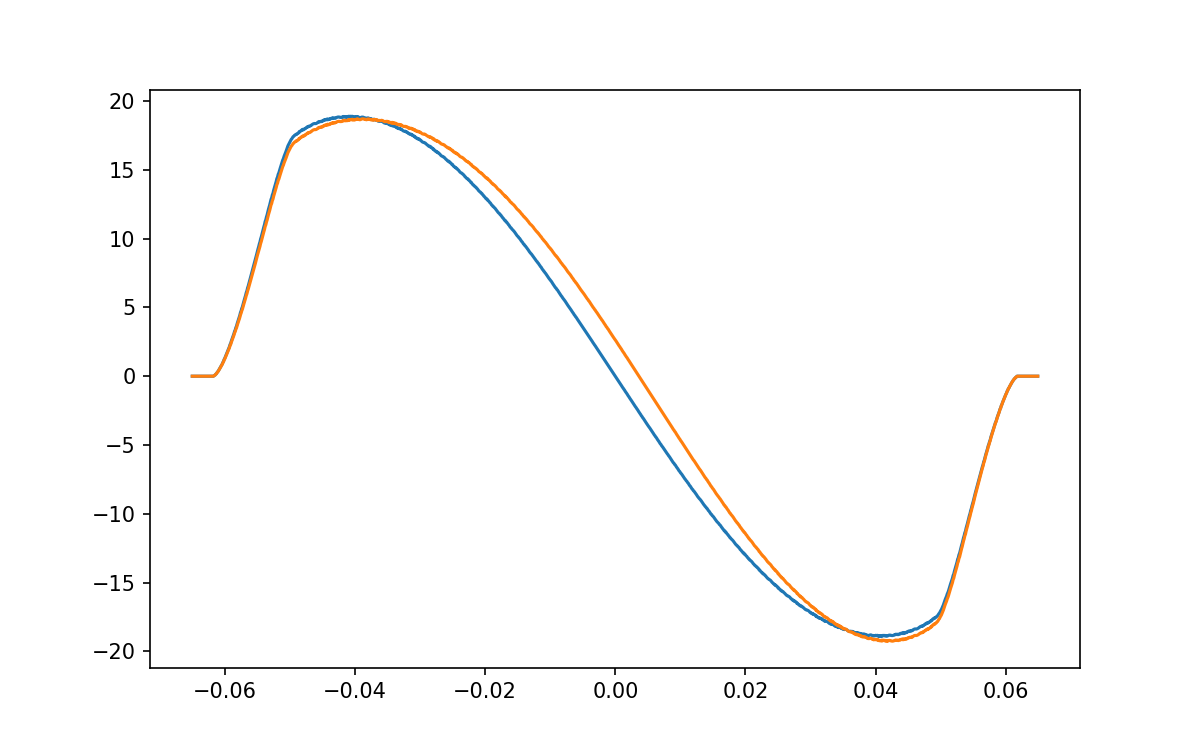

In [384]:
plt.figure(figsize=(8,5))
plt.plot(x0, model_noCB)
plt.plot(x0, model_withCB)
#plt.plot(x0, model_ohta)
#plt.scatter(x0, cont_Val)
plt.show()

In [157]:
0.1004 * 1.2 /1.1

0.10952727272727272